In [1]:
# load necessary modules
import numpy as np
import pandas as pd # for reading data
from matplotlib import pyplot as plt # for plotting
from scipy import optimize # for data fitting
from scipy import stats
from scipy import special
from scipy.stats import binom
import statistics

## Prepare data points for fitting

In [48]:
# read data from excel spreadsheet
data_file_path = r'C:\Users\reape\Desktop\Sp24\NPRE 451\Lab 1.xlsx'
df = pd.read_excel(data_file_path, header=None, sheet_name = '5 second trials')
data = df.T.to_numpy()[0]
print(data)

[48 55 47 42 39 48 45 51 43 47 45 50 39 36 37 48 60 41 43 58 52 43 43 46
 40 39 61 47 61 38 42 51 58 49 59 60 33 52 40 38 38 49 39 32 53 58 55 59
 46 53 48 44 51 50 42 52 49 63 48 47 54 42 39 42 44 54 53 40 44 49 42 50
 41 38 45 45 47 53 51 58 48 44 56 62 50 44 39 55 45 42 47 42 34 45 42 45
 65 53 42 49 47 39 50 58 35 47 49 59 51 48 48 50 51 51 32 49 42 39 62 55
 42 47 48 51 42 51 53 48 52 35 51 48 53 49 46 43 55 41 44 45 36 50 45 49
 49 39 41 52 53 36 45 44 59 45 41 50 45 45 45 49 50 58 52 57 44 57 51 38
 51 43 49 47 53 54 39 58 37 42 57 63 53 52 51 47 36 55 58 53 40 52 36 51
 65 50 49 51 60 46 41 46]


In [49]:
# calculate sample mean and standard deviation
sample_mean = statistics.mean(data)
sample_stdev = statistics.stdev(data)
print("Sample mean is {0}, standard deviation is {1}".format(sample_mean, sample_stdev))

Sample mean is 47, standard deviation is 7.0


In [72]:
# create the frequency of occurrence of the data set, i.e. the measured distribution
# grouping the counts in bins of width 1 from 1 to 20

#bin_width = 2*(2*sample_stdev)/200**(1/3)
#bin_num = int(np.around(35/bin_width)) 
#Didn't use the Freedman-Diaconis Rule as the bin number was only 7

occurrences, bin_edges = np.histogram(data, bins=17, range=(32, 66))
counts = bin_edges[:-1]

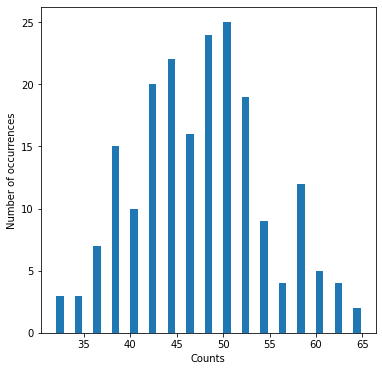

In [65]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
# ax.step(counts, occurrences, where='pre')
# ax.scatter(counts, occurrences)
# ax.stem(counts, occurrences)
ax.bar(counts, occurrences, align='edge')
ax.set_xlabel("Counts")
ax.set_ylabel("Number of occurrences")
plt.show()

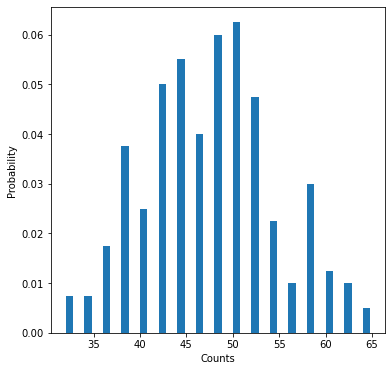

In [66]:
# normalize the sum to 1
bin_size = bin_edges[1] - bin_edges[0]
probabilities = occurrences/np.sum(occurrences)/bin_size
fig, ax = plt.subplots(1,1,figsize=(6,6))
# ax.step(counts, probabilities, where='mid')
# ax.scatter(counts, probabilities)
# ax.stem(counts, probabilities)
ax.bar(counts, probabilities, align='edge')
ax.set_xlabel("Counts")
ax.set_ylabel("Probability")
plt.show()

## Prepare the models

Three models will be tested: Poisson, Gaussian, and Binomial. The probability mass /density function is:

1.   Poisson distribution: $P(X=x)=e^{-\mu} \frac{\mu^x}{x!}$.
2.   Gaussian distribution: $f(X=x)=\frac{1}{\sqrt{2\pi}\sigma}\exp(\frac{-(x-\mu)^2}{2\sigma^2})$.
3.   Binomial distribution: $P(X=x)=\binom{n}{x}p^x(1-p)^{n-x}$.



In [67]:
# define the fit models
def poisson(x, mu):
    x = np.array(x)
    log_xf = np.zeros(len(x))
    for x_ind, x_val in enumerate(x):
        log_xf[x_ind] = special.loggamma(x_val+1)
    log_likelihood= -log_xf + x*np.log(mu) - mu
    return np.exp(log_likelihood)


def gaussian(x, mu, sigma):
    t = (x-mu)/sigma
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-t**2/2)


def binomial(x, n, p):
    return binom.pmf(x, n, p)

## Peform data fitting

### Initial guess of fit parameters
The fitting procedure requires an initial guess of the parameter(s) as a starting point.
1.   For poisson distribution, the mean is $\mu$. An initial guess of parameter $\mu$ is the mean of all samples.
2.   For Gaussian distribution, the mean is $\mu$ and standard deviation is $\sigma$.
3.   For binomial distribution, the mean is $Np$ and the variance is $Np(1-p)$. An initial guess of paramter $p$ is $1-$variance/mean, and mean/$p$ for $N$.

In [74]:
# fit the model to data
fit_results = [] # An empty array for storing the fitted parameters
models = [poisson, gaussian, binomial]
for model in models:
    if model == poisson:
        initial_guess = [sample_mean] # initial_guess = [YOUR GUESS FOR MU]
        bounds = (46, 48) # bounds = (MU LOWER BOUND, MU UPPER BOUND)
    if model == gaussian:
        initial_guess = [sample_mean, sample_stdev] # initial_guess = [YOUR GUESS FOR MU, YOUR GUESS FOR SIGMA]
        bounds = ([46, 6], [48, 8]) # bounds = ([MU LOWER BOUND, SIGMA LOWER BOUND], [MU UPPER BOUND, SIGMA UPPER BOUND])
    if model == poisson or model == gaussian:
        # the following line performs the fit
        best_fit_parameters, cov_matrix = optimize.curve_fit(model, counts, probabilities, p0 = initial_guess, bounds = bounds)
    if model == binomial:
        guess_of_p = 0.001 #potential change in here
        guess_of_N = (sample_mean / guess_of_p)
        initial_guess = [guess_of_N, guess_of_p] # initial_guess = [YOUR GUESS FOR N, YOUR GUESS FOR P]
        best_fit_parameters, cov_matrix = optimize.curve_fit(model, counts, probabilities, p0 = initial_guess, maxfev = 10000)
    fit_results.append([best_fit_parameters, cov_matrix])

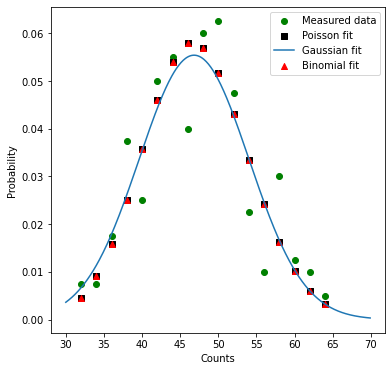

In [75]:
# plot the measured and fitted distributions and compare them
COUNT_LOWER_LIMIT = 30
COUNT_UPPER_LIMIT = 70
x_axis_counts = np.arange(COUNT_LOWER_LIMIT, COUNT_UPPER_LIMIT, 0.1)
labels = ['Poisson fit', "Gaussian fit", "Binomial fit"]
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(counts, probabilities, color='g', label="Measured data")
for i in range(3):
    best_fit_parameters, _ = fit_results[i]
    model = models[i]
    if i == 0:
        # poisson only work for integer values (discrete distribution)
        ax.scatter(counts, model(counts, *best_fit_parameters), marker='s', color='k', label=labels[i])
    elif i == 2:
        # binomial only work for integer values (discrete distribution)
        ax.scatter(counts, model(counts, *best_fit_parameters), marker='^', color='r', label=labels[i])
    else:
        # gaussian is continuous function
        ax.plot(x_axis_counts, model(x_axis_counts, *best_fit_parameters), label=labels[i])
ax.set_xlabel("Counts")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

## Compare the goodness of fit

In [76]:
# The R-squared metric is commonly use to detemine the goodness of the fit.
# It provides a measure of how well observed outcomes are replicated by the model,
# based on the proportion of total variation of outcomes explained by the model.
def get_fit_goodness(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [77]:
for i in range(3):
    best_fit_parameters, _ = fit_results[i]
    model = models[i]
    y_fit = model(counts, *best_fit_parameters)
    r2 = get_fit_goodness(probabilities, y_fit)
    print("Goodness of " + labels[i] + " is: " + str(r2))

Goodness of Poisson fit is: 0.7971721851396153
Goodness of Gaussian fit is: 0.8026833982774444
Goodness of Binomial fit is: 0.797170366368578
